### Analyzing a bike trip from Lyon to amsterdam 

We parse Strava gpx files and see what stats and plot we can make.

In [2]:
import gpxpy
import os
from pathlib import Path
from glob import glob
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
figsize_wide = figsize = [14,5]
import geopandas as gpd
from geopy import distance
from shapely.geometry import Point, Polygon

import sys
sys.path.insert(0, 'helper_functions/')
from gpx_parser import make_parser, print_gpx_info, make_parser

PATH = '/home/diederik/ams/pyprojects/geospatial_analysis/data/strava/'
p = Path(PATH)
files = list(p.rglob('*.gpx*'))

In [3]:
# commodity function found at 
# https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

## stats

get statistics to check for one the tracks

In [5]:
f = open('/home/diederik/ams/pyprojects/geospatial_analysis/data/strava/01_tape_1_Lyon_Albertville_.gpx', 'r')
gpx_file = gpxpy.parse(f)

args, gpx_files = make_parser().parse_known_args()
print_gpx_info(gpx = gpx_file,gpx_file='01_tape_1_Lyon_Albertville_.gpx')

File: 01_tape_1_Lyon_Albertville_.gpx
    Length 2D: 165.890km
    Length 3D: 166.034km
    Moving time: 07:22:29
    Stopped time: 00:37:28
    Max speed: 13.68m/s = 49.26km/h
    Avg speed: 6.25m/s = 22.51km/h
    Total uphill: 1887.68m
    Total downhill: 1751.28m
    Started: 2018-07-28 04:18:05
    Ended: 2018-07-28 12:18:02
    Points: 5823
    Avg distance between points: 28.49m

    Track #0, Segment #0
        Length 2D: 165.890km
        Length 3D: 166.034km
        Moving time: 07:22:29
        Stopped time: 00:37:28
        Max speed: 13.68m/s = 49.26km/h
        Avg speed: 6.25m/s = 22.51km/h
        Total uphill: 1887.68m
        Total downhill: 1751.28m
        Started: 2018-07-28 04:18:05
        Ended: 2018-07-28 12:18:02
        Points: 5823
        Avg distance between points: 28.49m



# load & analyze

In [6]:
def load_bike_data(gpx_files_path, filter=""):
    files = list(p.rglob('*.gpx*'))
    
    track_data = []
    
    for file_idx, file in enumerate(files): 
        try:
            gpx = gpxpy.parse(open(file, 'r'))
        except ValueError:
            print ('gpx files not loaded')
        # Loop through tracks
        for track_idx, track in enumerate(gpx.tracks):
            track_name = track.name
            track_time = track.get_time_bounds().start_time
            track_length = track.length_3d()
            track_duration = track.get_duration()
            moving_time, stopped_time, moving_distance, stopped_distance, max_speed = track.get_moving_data()
            uphill, downhill = track.get_uphill_downhill()
            
            for i, segment in enumerate(track.segments):
                segment_length = segment.length_3d()
                for point_idx, point in enumerate(segment.points):
                    track_data.append([file_idx, 
                                       track_name, 
                                       track_time, 
                                       track_length, 
                                       track_duration, 
                                       moving_time, stopped_time,moving_distance,stopped_distance,max_speed,
                                       uphill,downhill,
                                       i, 
                                       point.time, 
                                       point.latitude, 
                                       point.longitude, 
                                       point.elevation, 
                                       segment.get_speed(i)])
    return track_data

In [7]:
def create_dateparts_columns(df, datetime_col, date_fmt):
    """
    Convert string date column to datetime and add date, day, weekday and hour columns to dataframe
    INPUT:
     df: pandas df
     datetime_col: name column to be converted to datetime
     date_fmt: string format of datetime column
    RETURNS:
     dataframe with extra columns
    """
    df['point_time'] = pd.to_datetime(df[datetime_col], format = date_fmt)
    df = df.assign(date = lambda x: x[datetime_col].dt.date,
                   time = lambda x: x[datetime_col].dt.time,
                   day = lambda x: x[datetime_col].dt.day,
                   weekday = lambda x: x[datetime_col].dt.weekday,
                   hour = lambda x: x[datetime_col].dt.hour)
    return df

In [8]:
data = load_bike_data(gpx_files_path=PATH, filter="")
df = pd.DataFrame(data, columns=['file_index', 'etappe', 'time', 'length', 'duration', 'moving_time', 
                                 'stopped_time', 'moving_distance', 'stopped_distance','max_speed', 
                                 'uphill','downhill','segment_index', 'point_time', 
                                 'lat', 'lon', 'elev', 'speed'])
df = create_dateparts_columns(df, datetime_col='point_time', date_fmt='%Y-%m-%d %H:%M:%S')

In [9]:
def munge_gpx_dataframe(df, file_index):
    
    print ("parsing file_index= {}".format(file_index))
    df = df[df.file_index == file_index]
    df = df.sort_values(by = ['file_index', 'point_time'], ascending=[True, True])
    
    df = df.copy()
    df['max_speed'] = (df['max_speed'] *3600. / 1000.) # to km/h
    # new start_time column 
    df['start_time'] = 'no'
    df.loc[df.point_time == df.point_time.iloc[0], 'start_time'] = 'start_time'
    df.loc[df.point_time == df.point_time.iloc[-1], 'start_time'] = 'end_time'
    # duration to hours
    df['duration'] = (df['duration']/60./60.)
    # length to km 
    df['length'] = (df.length/1000.).map('{:.1f}km'.format)
    
    # get segment index
    df['segment_index'] = pd.Series(range(0, len(df)),dtype='int', index=df.index)
    
    # elev_change
    df['elev_change'] = df.elev.subtract(df.elev.shift())
    
    # time_diff
    df['time_diff'] = pd.to_timedelta(df['time'].astype(str)).diff()
    df['time_diff_s'] = df.time_diff.dt.seconds
    
    # calculate distance off every subsegment in track (df needs to be correctly ordered time-wise -asc)
    segment_dist_list_ = []
    for i in range(0, len(df.segment_index)):
        if i < range(0, len(df.segment_index))[-1]:
            (segment_dist_list_.append(
                distance.vincenty(
                 tuple((df.loc[(df.segment_index == i, ['lat', 'lon'])].values)
                       .reshape(1, -1)[0]),
                 tuple((df.loc[(df.segment_index == i + 1, ['lat', 'lon'])].values)
                       .reshape(1, -1)[0])
                ).m) # meters
            )
        else:
            segment_dist_list_.append(0)
    df['length_segment'] = pd.DataFrame(segment_dist_list_, index=df.index)
    
    # speed df km/h {:.2f}km/h
    df['speed_kmh'] = (df['length_segment']/1000).div((df['time_diff_s'] / 3600))
    df['speed_ms'] = (df['length_segment']).div((df['time_diff_s']))
    
    threshold = 0.66
    df['mov'] = np.where(df.speed_kmh <= threshold, 'stopping', 'moving')
    
    # length to km 
    df['moving_time'] = (df['moving_time']/60./60.).map('{:.2f}'.format)
    df['stopped_time'] = (df['stopped_time']/60./60.).map('{:.2f}'.format)
    df['moving_distance'] = (df['moving_distance']/1000).map('{:.1f}km'.format)
    df['stopped_distance'] = (df['stopped_distance']/1000).map('{:.1f}km'.format)
    
    return df

In [10]:
# oepss files where not ordered chronologically, the correct order of the etappes (file_list-wise) is:
file_index_order = [4, 7, 2, 3, 8, 6, 10, 9, 1, 5, 0, 11]
file_index_order_test = [4,7]
appended_date = []
for file_ind in file_index_order_test:
    appended_date.append(munge_gpx_dataframe(df=df, file_index=file_ind))

parsing file_index= 4
parsing file_index= 7


In [11]:
df = pd.concat(appended_date)

In [13]:
#df

In [119]:
#df.to_csv(PATH + 'munged_strava_data.csv', index=False)

In [122]:
test = pd.read_csv(PATH + 'munged_strava_data.csv')

# plots 

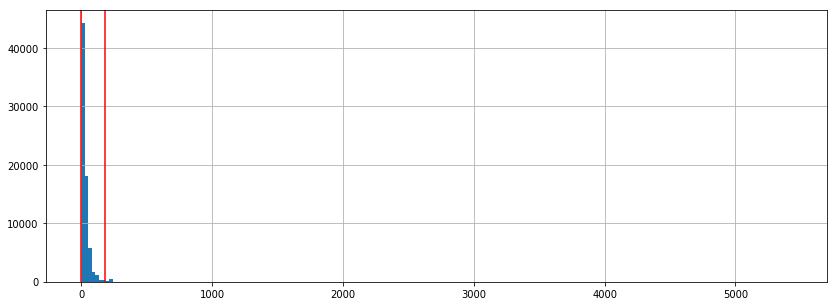

In [123]:
# there is something with the speed
_, bins = pd.qcut(test.speed_kmh, q=[0.01, 0.99], retbins=True)
ax = test.speed_kmh.hist(bins=200, figsize=figsize_wide)

for b in bins:
    ax.axvline(b, color='r')

In [124]:
# let's choose a speed threshold under which we will qualify as 'not moving'. We choose to end up as 
# closely as possible to Strava's registered 'Stopped time: 03:12:02'
for threshold in list(np.linspace(0,2,10)):
    print (test[(test.speed_kmh <= threshold)]['time_diff'].sum(), threshold)

0 days 00:00:01.0000000000 days 00:00:02.0000000000 days 00:00:01.0000000000 days 00:00:02.0000000000 days 00:00:02.0000000000 days 00:00:02.0000000000 days 00:00:01.0000000000 days 00:00:05.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:01.0000000000 days 00:00:05.0000000000 days 00:00:02.0000000000 days 00:00:04.0000000000 days 00:00:01.0000000000 days 00:00:01.0000000000 days 00:00:04.0000000000 days 00:00:01.0000000000 days 00:00:01.0000000000 days 00:00:01.0000000000 days 00:00:02.0000000000 days 00:00:01.0000000000 days 00:00:05.0000000000 days 00:00:04.0000000000 days 00:00:10.0000000000 days 00:00:02.0000000000 days 00:00:02.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:07.0000000000 days 00:00:06.0000000000 days 00:00:15.0000000000 days 00:00:05.0000000000 days 00:00:06.0000000000 days 00:00:04.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:02.000000000

0 days 00:00:01.0000000000 days 00:00:02.0000000000 days 00:00:01.0000000000 days 00:00:02.0000000000 days 00:00:02.0000000000 days 00:00:02.0000000000 days 00:00:01.0000000000 days 00:00:05.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:01.0000000000 days 00:00:05.0000000000 days 00:00:02.0000000000 days 00:00:04.0000000000 days 00:00:01.0000000000 days 00:00:01.0000000000 days 00:00:04.0000000000 days 00:00:01.0000000000 days 00:00:01.0000000000 days 00:00:01.0000000000 days 00:00:02.0000000000 days 00:00:01.0000000000 days 00:00:05.0000000000 days 00:00:04.0000000000 days 00:00:10.0000000000 days 00:00:02.0000000000 days 00:00:02.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:07.0000000000 days 00:00:06.0000000000 days 00:00:15.0000000000 days 00:00:05.0000000000 days 00:00:06.0000000000 days 00:00:04.0000000000 days 00:00:03.0000000000 days 00:00:03.0000000000 days 00:00:02.000000000

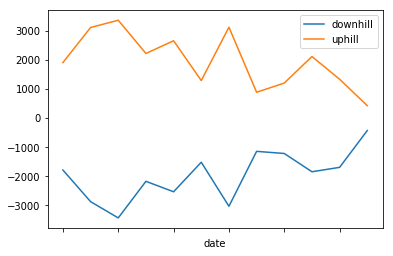

In [129]:
# this threshold seems not too bad as the up & downhill stats correspond pretty well with Strava's
(test.query("mov == 'moving'").groupby(['date'])['elev_change'].agg([('downhill' , lambda x : x[x <= 0].sum()) , 
                                           ('uphill' , lambda x : x[x >= 0].sum())])).plot()

In [26]:
# for reindexing purposes to show full day
date = test['date'][0]
time_range = pd.date_range(f"{date} 00:00:00",  f"{date} 23:00:00", freq='1min')

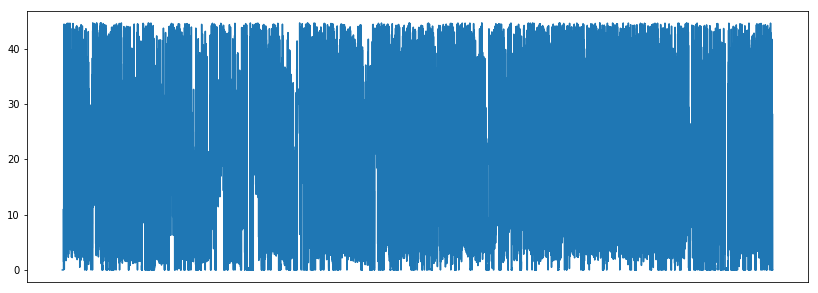

In [135]:
fig, ax = plt.subplots(figsize = figsize_wide)
reject_outliers(test.speed_kmh.dropna()).plot(ax=ax)
ax.xaxis.set_major_locator(dates.HourLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))

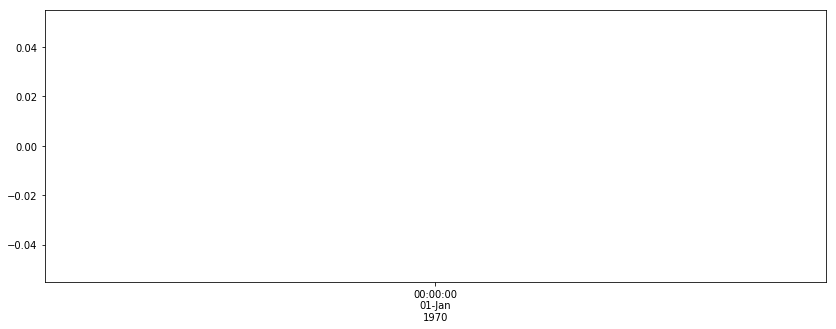

In [136]:
fig, ax = plt.subplots(figsize=figsize_wide)
(test.sort_index().reindex(time_range,fill_value=np.nan)
 .resample('10min')['elev'].mean().plot(ax=ax))

In [137]:
reject_outliers(test.speed_kmh)

/home/diederik/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Series([], Name: speed_kmh, dtype: float64)

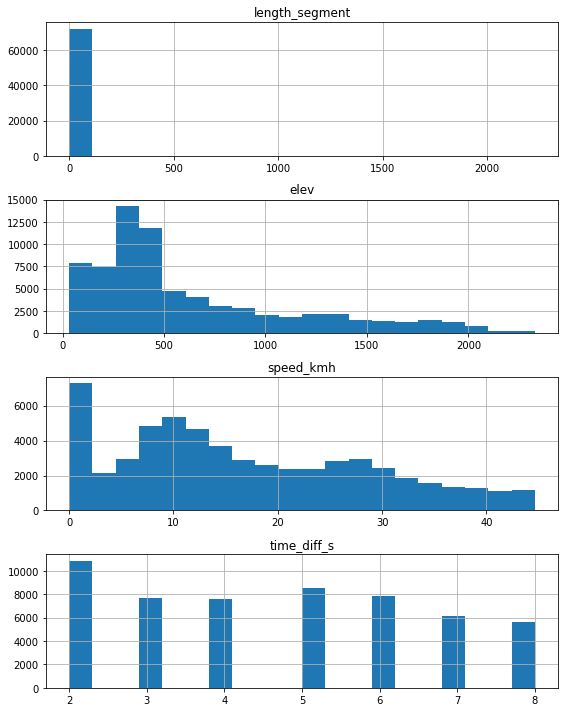

In [132]:
num_cols = ['length_segment', 'elev','speed_kmh', 'time_diff_s']
fig, ax = plt.subplots(len(num_cols), 1, figsize= [8,10])

for i, col in enumerate(test[num_cols].columns):
    if col == 'speed_kmh' or col== 'time_diff_s':
        reject_outliers(test[col].dropna()).hist(bins=20, ax=ax[i])
        ax[i].set_title(col)
    else:
        test[col].dropna().hist(bins=20, ax=ax[i])
        ax[i].set_title(col)
plt.tight_layout()

In [231]:
df['elev_bins'] = pd.cut(df['elev'], bins = [0, 500, 1000, 1500, 2000], 
                         labels=['0-500', '500-1000', '1000-1500', '1500-2000'])

## geo plots

In [42]:
df

,file_index,etappe,time,length,duration,moving_time,stopped_time,moving_distance,stopped_distance,max_speed,uphill,downhill,segment_index,point_time,lat,lon,elev,speed,date,day,weekday,hour,geometry
0,0,Étape 11# Achouffe - Eindhoven,04:26:22,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:22,50.164228,5.673490,412.8,5.082558,2018-08-09,9,3,4,POINT (5.67349 50.164228)
1,0,Étape 11# Achouffe - Eindhoven,04:26:23,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:23,50.164232,5.673561,412.8,5.082558,2018-08-09,9,3,4,POINT (5.673561 50.164232)
2,0,Étape 11# Achouffe - Eindhoven,04:26:24,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:24,50.164238,5.673631,412.6,5.082558,2018-08-09,9,3,4,POINT (5.673631 50.164238)
3,0,Étape 11# Achouffe - Eindhoven,04:26:25,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:25,50.164244,5.673700,412.8,5.082558,2018-08-09,9,3,4,POINT (5.6737 50.164244)
4,0,Étape 11# Achouffe - Eindhoven,04:26:26,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:26,50.164247,5.673769,412.6,5.082558,2018-08-09,9,3,4,POINT (5.673769 50.164247)
5,0,Étape 11# Achouffe - Eindhoven,04:26:28,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:28,50.164241,5.673909,412.6,5.082558,2018-08-09,9,3,4,POINT (5.673909 50.164241)
6,0,Étape 11# Achouffe - Eindhoven,04:26:32,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:32,50.164205,5.674203,412.4,5.082558,2018-08-09,9,3,4,POINT (5.674203 50.164205)
7,0,Étape 11# Achouffe - Eindhoven,04:26:42,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:42,50.164141,5.675041,412.2,5.082558,2018-08-09,9,3,4,POINT (5.675041 50.164141)
8,0,Étape 11# Achouffe - Eindhoven,04:26:48,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:48,50.164116,5.675530,412.0,5.082558,2018-08-09,9,3,4,POINT (5.67553 50.164116)
9,0,Étape 11# Achouffe - Eindhoven,04:26:55,212903.314999,43775,32253.0,11522.0,212700.325587,202.989412,13.268900,1356.92,1699.32,0,2018-08-09 04:26:55,50.164014,5.676042,411.6,5.082558,2018-08-09,9,3,4,POINT (5.676042 50.164014)


In [138]:
#to geopandas
df_geo = gpd.GeoDataFrame(test, crs = {'init': 'epsg:4326'})
df_geo['geometry'] = df_geo.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

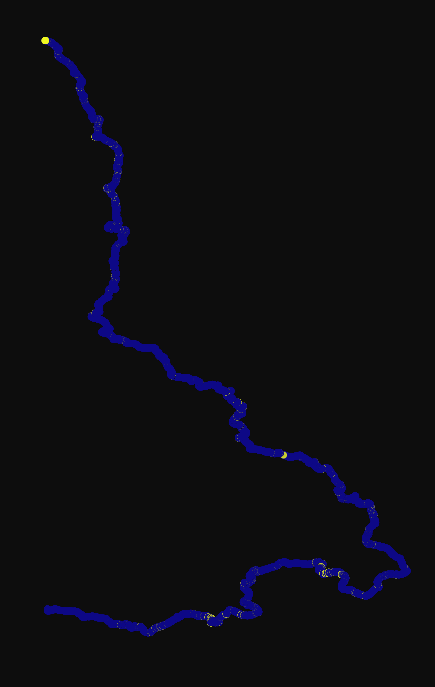

In [139]:
fig,ax = plt.subplots(figsize = [37,12], facecolor = '0.05')
#ax.set_aspect('equal')
ax.set_axis_off()
df_geo.plot(lw = 0.9, alpha = 0.8, ax=ax, column = 'mov', cmap ='plasma')